In [1]:
%matplotlib inline

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# Interpreting scikit-learn machine learning models

## Dataset: Current Population Survey (1985)

We will use data from the "Current Population Survey" from 1985 and fetch it from [OpenML](http://openml.org/).

In [4]:
from sklearn.datasets import fetch_openml

censing = fetch_openml(data_id=534, return_frame=True)
censing.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

We can get more information regarding by looking at the description of the dataset.

In [5]:
print(censing.DESCR)

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

Determinants of Wages from the 1985 Current Population Survey

Summary:
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. We wish to determine (i) whether wages are related to these characteristics and (ii) whether there is a gender gap in wages.
Based on residual plots, wages were log-transformed to stabilize the variance. Age and work experience were almost perfectly correlated (r=.98). Multiple regression of log wages against sex, age, years of education, work experience, union membership, southern residence, and occupational status showed that these covariates were related to wages (pooled F test, 

The data are stored in a pandas dataframe.

In [6]:
censing.data.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR,WAGE
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married,5.10
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married,4.95
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried,6.67
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried,4.00
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married,7.50


In [7]:
censing.target_names

['WAGE']

The column **WAGE** is our target variable (i.e., the variable which we want to predict). You can note that the dataset contains both numerical and categorical data.

First, let's get some insights by looking at the **marginal** links between the different variables. Only *numerical* variables will be used. 

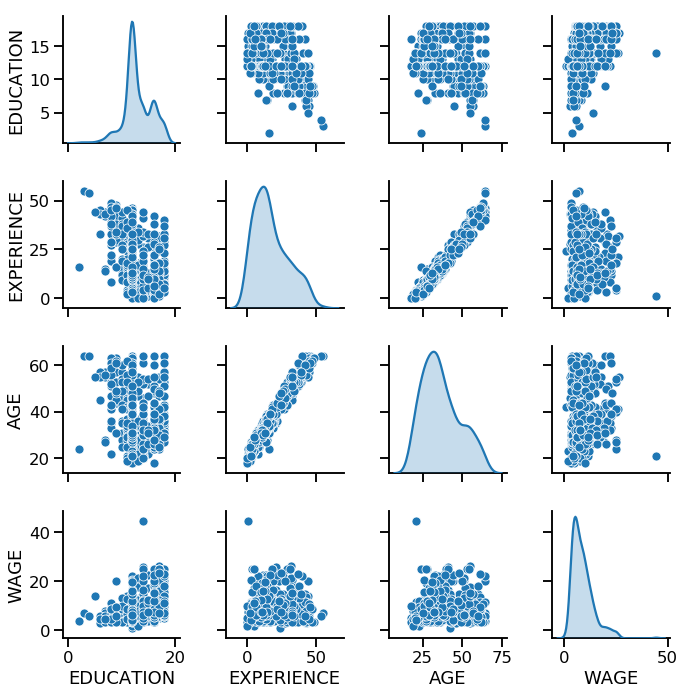

In [8]:
sns.pairplot(censing.data, diag_kind='kde');

We can add some additional information to the previous plots.

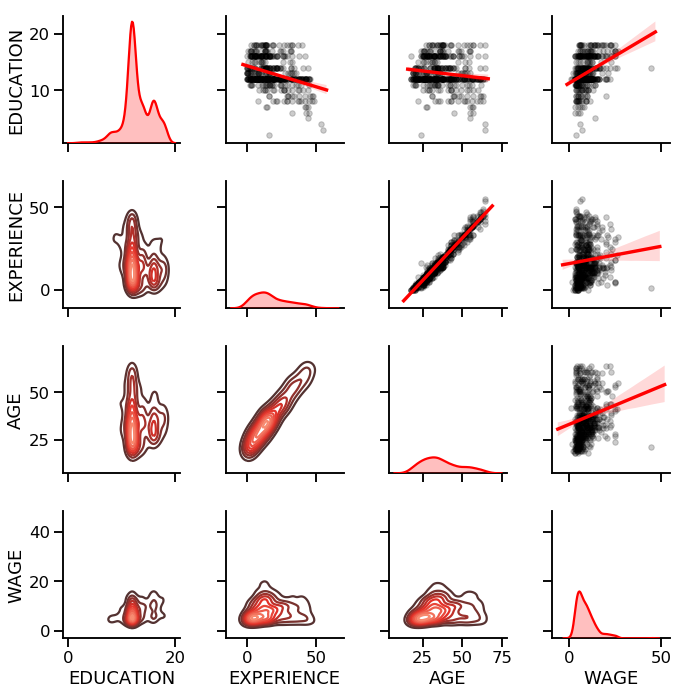

In [9]:
g = sns.PairGrid(censing.data)
g = g.map_upper(
    sns.regplot, scatter_kws={"color": "black", "alpha": 0.2, "s": 30},
    line_kws={"color": "red"}
)
g = g.map_lower(sns.kdeplot, cmap="Reds_d")
g = g.map_diag(sns.kdeplot, shade=True, color='r')

We can already have some intuitions regarding our dataset:

* The "WAGE" distribution has a long tail and we could work by taking the `log` of the wage;
* For all 3 variables, "EDUCATION", "EXPERIENCE", and "AGE", the "WAGE" is increasing when these variables are increasing;
* The "EXPERIENCE" and "AGE" are correlated.

It is important to point out that we analyzed the data by looking at the joint distribution between 2 variables which is a **marginal** link.

We will shortly jump into interpreting the coefficients of linear model. In this regard, we should emphasize that linear models compute **conditional** links. All interpretation of the value coefficient given the relationship between the feature and the target given that other features remain constant. For instance, we can deduce the relationship between the "AGE" and "WAGE" for a given number of year of "EXPERIENCE".

## Interpret coefficients of linear models

In [10]:
X = censing.data[censing.feature_names]
y = censing.data[censing.target_names].values.ravel()

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

We have heterogeneous data and we will need to make a specific preprocessing for each data types.

In [12]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    remainder='passthrough'
)

Thus, the `preprocessor` will:

* one-hot encode (i.e., generate a column by category) the categorical columns;
* replace by 0 and 1 the categories of binary columns;
* keep numerical values as they are.

We will fit a ridge regressor and transform the target before the fit using a log transform.

In [13]:
import numpy as np
import scipy as sp
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
model.fit(X_train, y_train);

We can check the performance of the model which fitted.

In [14]:
from sklearn.metrics import median_absolute_error

y_pred = model.predict(X_test)
print(f'MAE = {median_absolute_error(y_test, y_pred):.2f} $/hour')

MAE = 2.07 $/hour


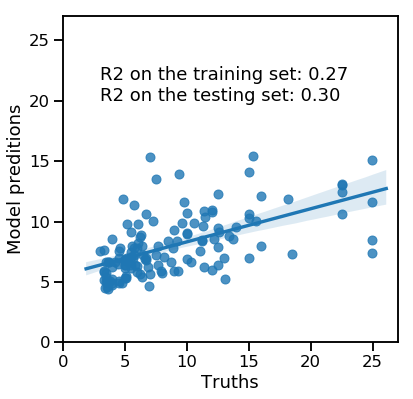

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(y_test, y_pred)

r2 = (f'R2 on the training set: {model.score(X_train, y_train):.2f}\n'
      f'R2 on the testing set: {model.score(X_test, y_test):.2f}')
plt.text(3, 20, r2)

plt.ylabel('Model preditions')
plt.xlabel('Truths')
plt.xlim([0, 27])
plt.ylim([0, 27]);

The model learnt is far to be a good model making accurate prediction. Interpretation tools are characterizing model rather than the generative process of the data itself. Thus, interpretations are correct if the model is correct as well.

So now, we can plot the values of the coefficients of the regressor which we fitted.

In [16]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

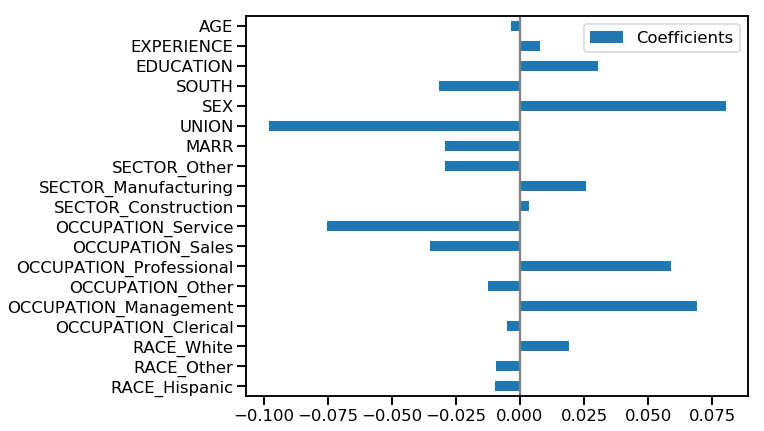

In [17]:
import pandas as pd

coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.axvline(x=0, color='.5');

One limitation is that we cannot compare the different weights since we did not scale the data during fit and that features can have different range. For instance, the "AGE" coefficient is expressed in `$/hours/leaving years` while the "EDUCATION" is expressed in `$/hours/years of education`.

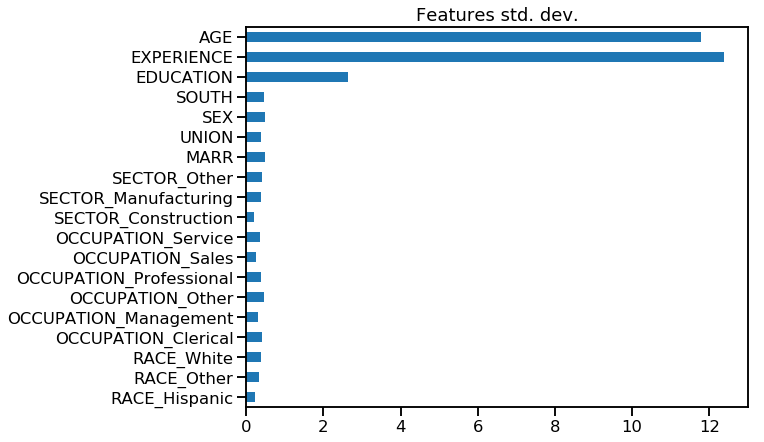

In [18]:
X_train_preprocessed = pd.DataFrame(
    model.named_steps['columntransformer'].transform(X_train),
    columns=feature_names
)
X_train_preprocessed.std().plot(kind='barh', figsize=(9, 7))
plt.title('Features std. dev.');

We can normalize the weights by the standard deviation and then we will be able to compare the different weights.

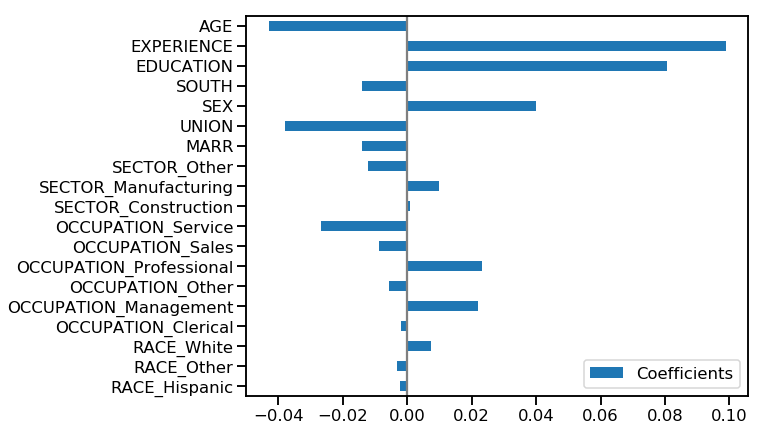

In [19]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_ *
    X_train_preprocessed.std(),
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.axvline(x=0, color='.5');

The way that we can interpret these values is as follow. An increase of the "AGE" will induce a decrease of the "WAGE" when all other features remain constant or an increase of the "EXPERIENCE" will induce an increase of the "WAGE" when all other features remain constant.

The first interpretation might look counter-intuitive at first, if one relates the relationship between "AGE" and "WAGE" as a *marginal* link. However, as previously mentioned, a linear model computes a *conditional* link between "AGE" and "WAGE" given all other features.

Therefore, one could interpret that for a given experience (and all other features constant as well ...), a younger person would have an higher wage.

Up to now, we did not check the stability of the coefficients and it would be important to check it to ensure through cross-validation.

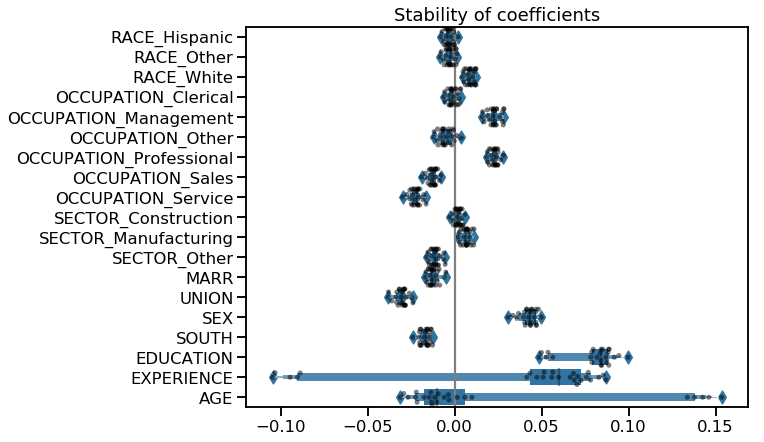

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.std()
     for est in cv_model['estimator']],
    columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxenplot(data=coefs, orient='h', color='C0')
plt.axvline(x=0, color='.5')
plt.title('Stability of coefficients');

The "AGE" and "EXPERIENCE" are highly instable which might be due to the collinearity between the 2 features. We can remove on of the 2 features and check what is the impact on the features stability.

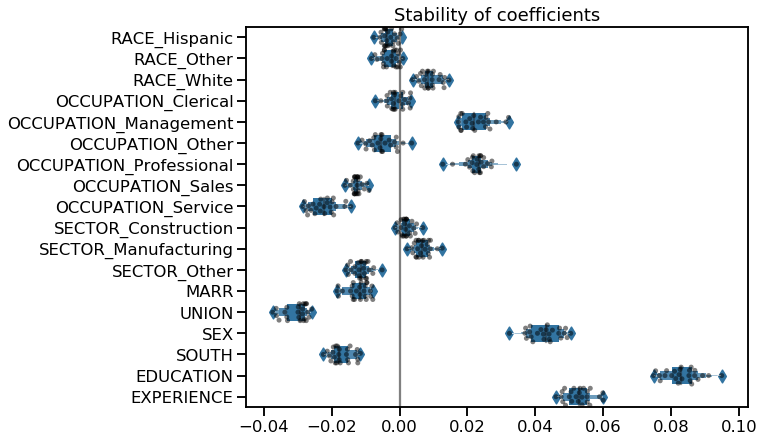

In [21]:
column_to_drop = ['AGE']

cv_model = cross_validate(
    model, X.drop(columns=column_to_drop), y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.drop(columns=column_to_drop).std()
     for est in cv_model['estimator']],
    columns=feature_names[:-1]
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxenplot(data=coefs, orient='h', color='C0')
plt.axvline(x=0, color='.5')
plt.title('Stability of coefficients');

With real-life dataset, data are leaving in a high-dimensional space where features are correlated and to make thing more difficult, we can have a limited number of samples. In this condition, estimating the coefficients is really difficult and we use regularization.

Ridge implements a $l_2$ regularization and we could use instead lasso which uses $l_1$. Lasso will select a subgroup of variable. However, it will be instable.

In [22]:
from sklearn.linear_model import LassoCV

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(max_iter=10000, cv=5),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
model.fit(X_train, y_train);

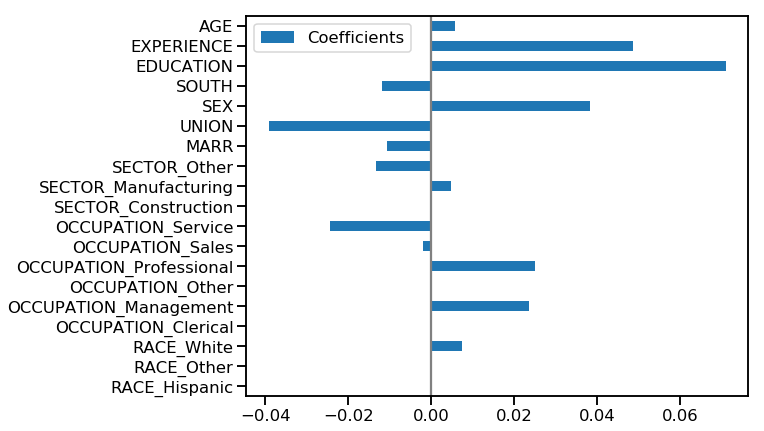

In [23]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_ *
    X_train_preprocessed.std(),
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.axvline(x=0, color='.5');

We can observed that some of the variables have been dropped. We can now check the stability of the coefficients.

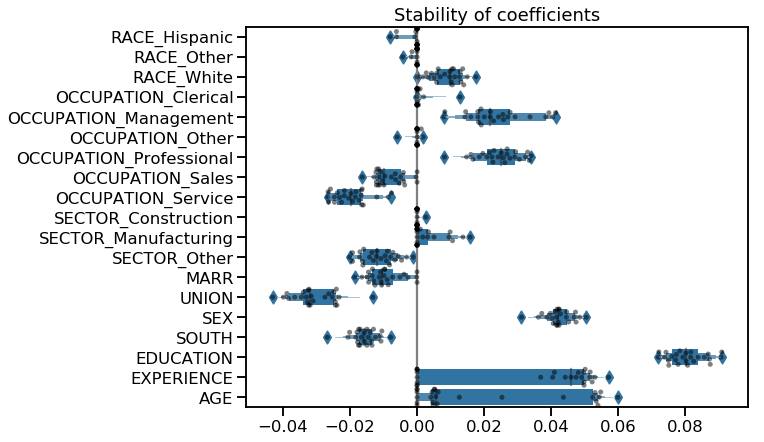

In [24]:
cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.std()
     for est in cv_model['estimator']],
    columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxenplot(data=coefs, orient='h', color='C0')
plt.axvline(x=0, color='.5')
plt.title('Stability of coefficients');

### Take-home message

* linear model coefficients represent conditional link between a variable and the target;
* coefficients cannot be compared if they were not normalized;
* regularization will be used when a problem starts to be complexed;
* collinearity makes interpretation difficult;
* interpretations charactized the model learnt rather than the process that generated the data.

## Interpret tree-based models

In [25]:
X = censing.data[censing.feature_names]
y = censing.data[censing.target_names].values.ravel()

X['random_cat'] = np.random.randint(3, size=X.shape[0])
X['random_num'] = np.random.randn(X.shape[0])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

### Random Forest importances of an overfitted model

In [27]:
from sklearn.ensemble import RandomForestRegressor

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR', 'random_cat']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE', 'random_num']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    remainder='passthrough'
)

model = make_pipeline(
    preprocessor,
    RandomForestRegressor(min_samples_leaf=1, random_state=42)
)
model.fit(X_train, y_train)

print("RF train accuracy: %0.3f" % model.score(X_train, y_train))
print("RF test accuracy: %0.3f" % model.score(X_test, y_test))

RF train accuracy: 0.885
RF test accuracy: 0.311


In [28]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

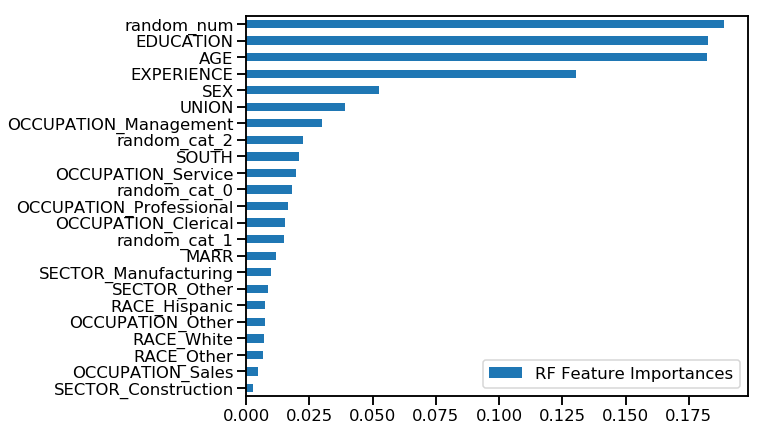

In [29]:
tree_feature_importances = pd.DataFrame(
    model.named_steps['randomforestregressor'].feature_importances_,
    index=feature_names,
    columns=['RF Feature Importances']
)
(tree_feature_importances.sort_values(by='RF Feature Importances')
                         .plot(kind='barh', figsize=(9, 7)));

### Permutation importances on the test set

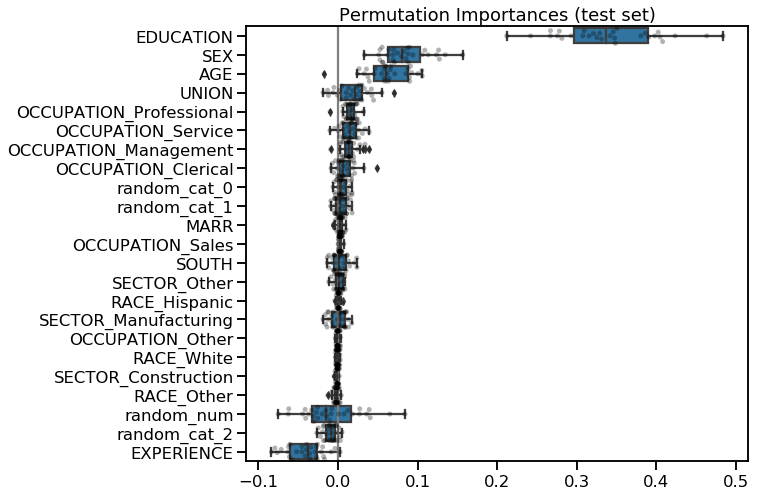

In [31]:
from sklearn.inspection import permutation_importance

X_test_preprocessed = (model.named_steps['columntransformer']
                            .transform(X_test))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_test_preprocessed, y_test, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (test set)");

### Permutation importances on the training set

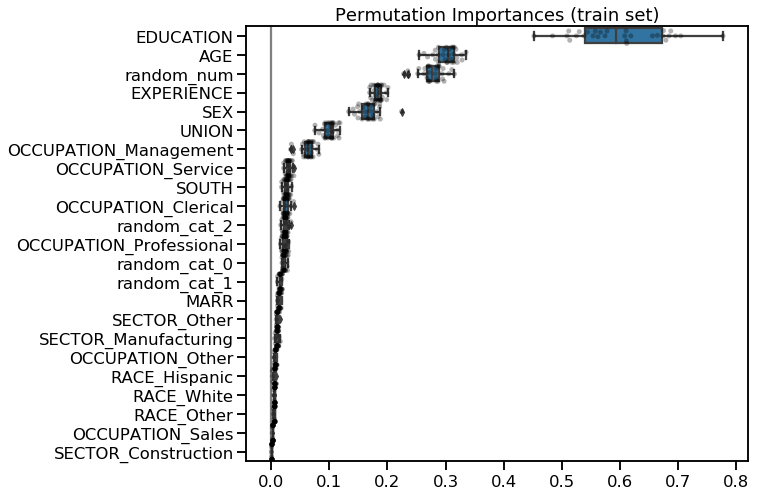

In [32]:
X_train_preprocessed = (model.named_steps['columntransformer']
                             .transform(X_train))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_train_preprocessed, y_train, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (train set)");

### Same analysis on a non-overfitted model

In [33]:
model.set_params(randomforestregressor__min_samples_leaf=10)
model.fit(X_train, y_train)

print("RF train accuracy: %0.3f" % model.score(X_train, y_train))
print("RF test accuracy: %0.3f" % model.score(X_test, y_test))

RF train accuracy: 0.412
RF test accuracy: 0.350


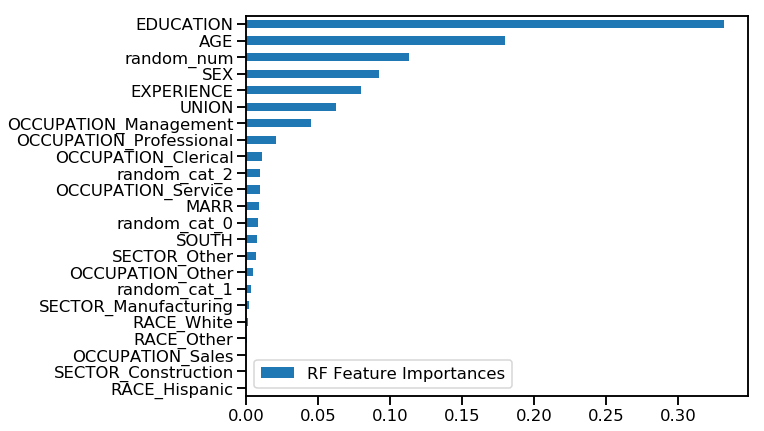

In [34]:
tree_feature_importances = pd.DataFrame(
    model.named_steps['randomforestregressor'].feature_importances_,
    index=feature_names,
    columns=['RF Feature Importances']
)
(tree_feature_importances.sort_values(by='RF Feature Importances')
                         .plot(kind='barh', figsize=(9, 7)));

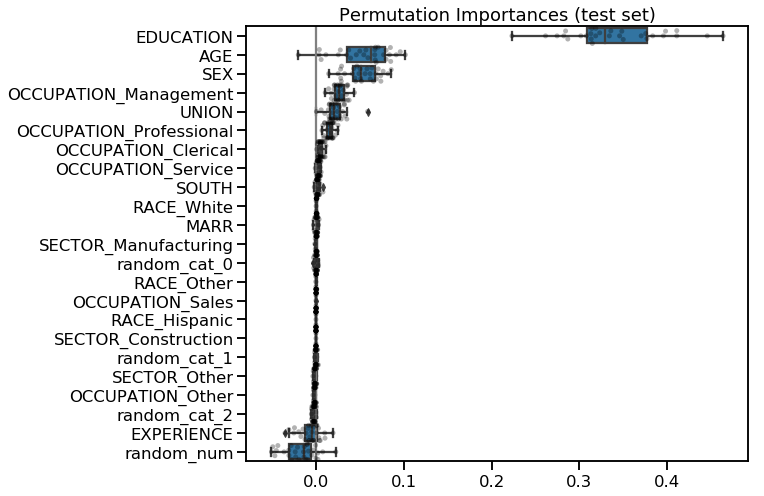

In [35]:
permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_test_preprocessed, y_test, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (test set)");

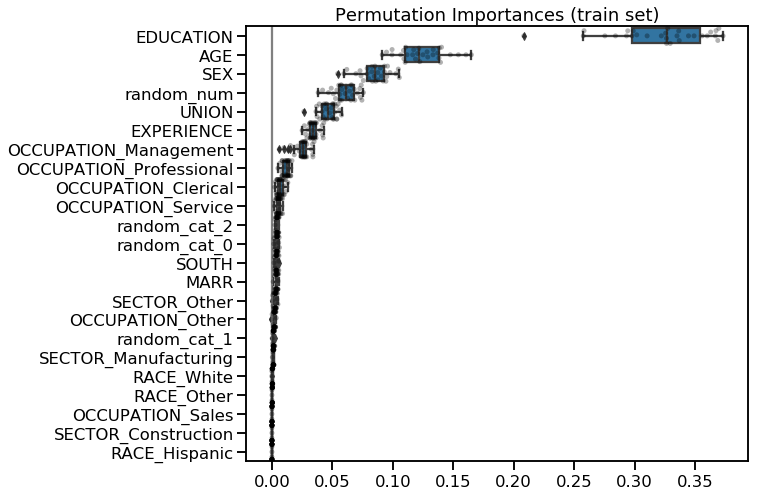

In [36]:
permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_train_preprocessed, y_train, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (train set)");

### Remove collinear variables

In [37]:
column_to_drop = ['AGE']

In [38]:
model.fit(X_train.drop(columns=column_to_drop), y_train)

print("RF train accuracy: %0.3f" % model.score(X_train.drop(columns=column_to_drop), y_train))
print("RF test accuracy: %0.3f" % model.score(X_test.drop(columns=column_to_drop), y_test))

RF train accuracy: 0.409
RF test accuracy: 0.354


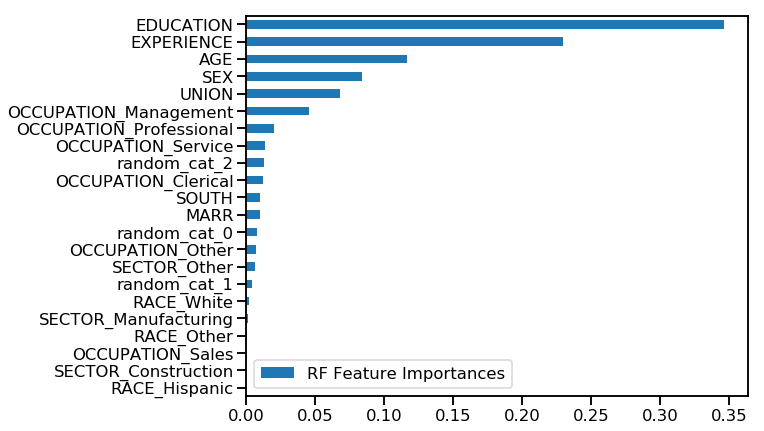

In [39]:
tree_feature_importances = pd.DataFrame(
    model.named_steps['randomforestregressor'].feature_importances_,
    index=feature_names[:-1],
    columns=['RF Feature Importances']
)
(tree_feature_importances.sort_values(by='RF Feature Importances')
                         .plot(kind='barh', figsize=(9, 7)));

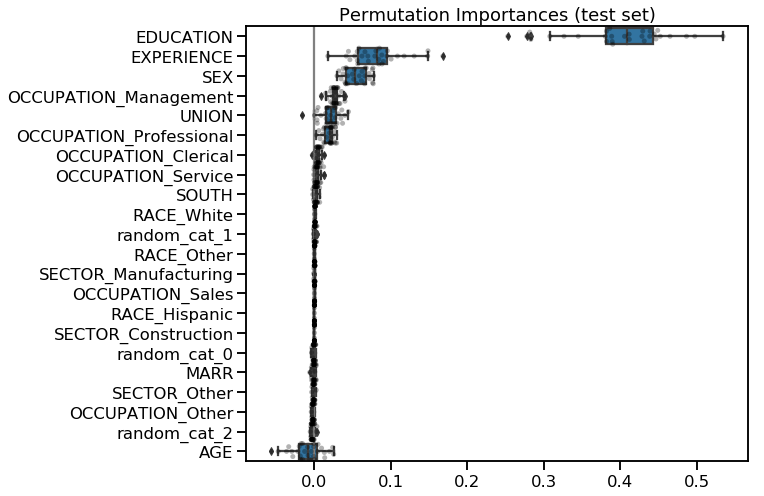

In [40]:
X_test_preprocessed = (model.named_steps['columntransformer']
                            .transform(X_test.drop(columns=column_to_drop)))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_test_preprocessed, y_test, n_rounds=30),
    index=feature_names[:-1]
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (test set)");

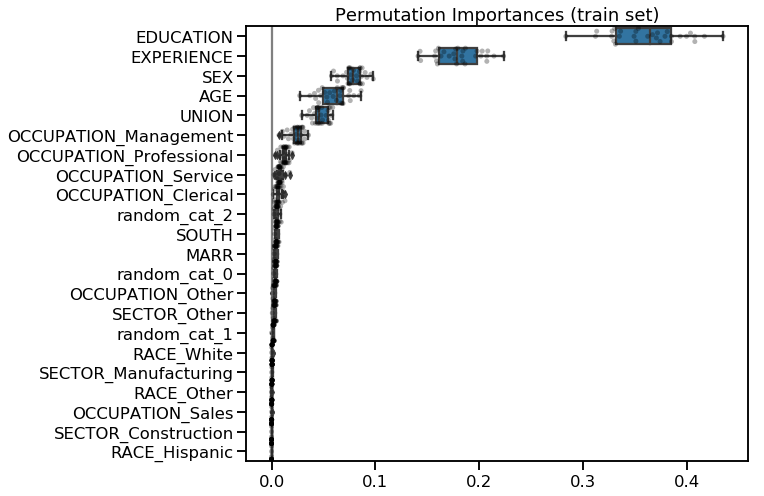

In [41]:
X_train_preprocessed = (model.named_steps['columntransformer']
                             .transform(X_train.drop(columns=column_to_drop)))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['randomforestregressor'],
                           X_train_preprocessed, y_train, n_rounds=30),
    index=feature_names[:-1]
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (train set)");

**TODO: refer to the example of the PR using the correlation/clustering**

### Permutation importance for other type of models

In [42]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
model.fit(X_train, y_train);

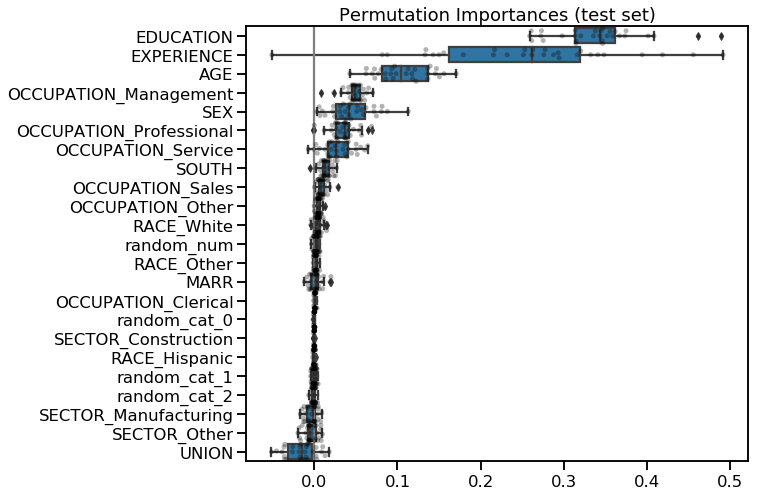

In [43]:
X_test_preprocessed = (model.named_steps['columntransformer']
                            .transform(X_test))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['transformedtargetregressor'],
                           X_test_preprocessed, y_test, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (test set)");

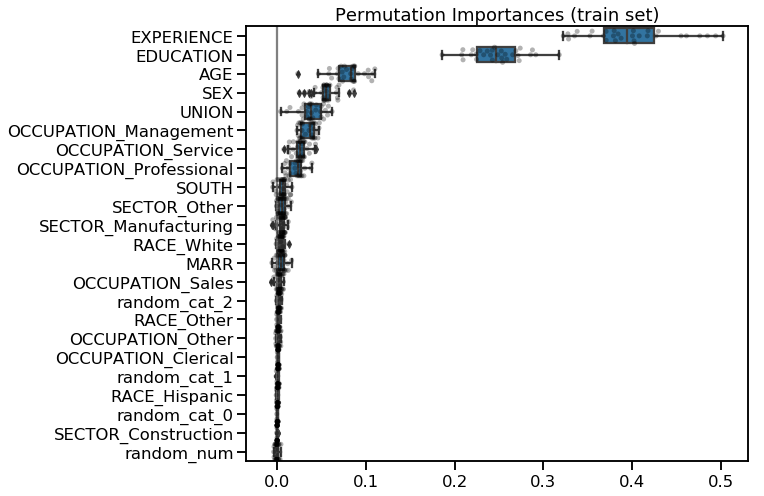

In [44]:
X_train_preprocessed = (model.named_steps['columntransformer']
                             .transform(X_train))

permute_importance = pd.DataFrame(
    permutation_importance(model.named_steps['transformedtargetregressor'],
                           X_train_preprocessed, y_train, n_rounds=30),
    index=feature_names
)
sorted_idx = (permute_importance.mean(axis=1)
                                .sort_values(ascending=False)
                                .index)

plt.figure(figsize=(9, 8))
sns.boxplot(data=permute_importance.loc[sorted_idx].T,
            orient='h', color='C0')
sns.swarmplot(data=permute_importance.loc[sorted_idx].T,
              orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (train set)");

### Take-home message

* random forest feature importances suffer from bias;
* permutation importances allievate these issues;
* permutation importances will minimize the importance of correlated features;
* permutation importances is model agnostic.


Partial Dependence Plots

Partial dependence plots show the dependence between the target function [2]_
and a set of 'target' features, marginalizing over the
values of all other features (the complement features). Due to the limits
of human perception the size of the target feature set must be small (usually,
one or two) thus the target features are usually chosen among the most
important features.

This example shows how to obtain partial dependence plots from a
:class:`~sklearn.neural_network.MLPRegressor` and a
:class:`~sklearn.ensemble.HistGradientBoostingRegressor` trained on the
California housing dataset. The example is taken from [1]_.

The plots show four 1-way and two 1-way partial dependence plots (ommitted for
:class:`~sklearn.neural_network.MLPRegressor` due to computation time).
The target variables for the one-way PDP are: median income (`MedInc`),
average occupants per household (`AvgOccup`), median house age (`HouseAge`),
and average rooms per household (`AveRooms`).

/home/lemaitre/Documents/code/toolbox/scikit-learn/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


done in 5.751s
Test R2 score: 0.81
Computing partial dependence plots...
done in 2.519s
Training GradientBoostingRegressor...
done in 1.091s
Test R2 score: 0.86
Computing partial dependence plots...
done in 0.334s


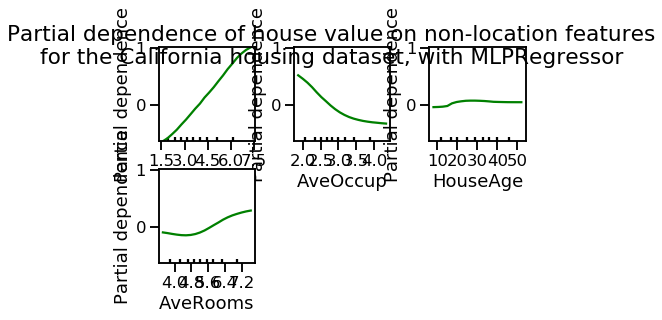

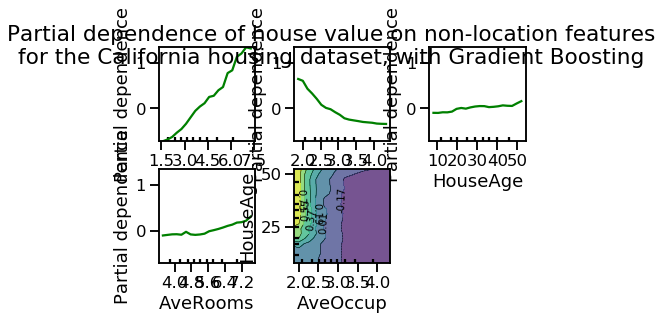

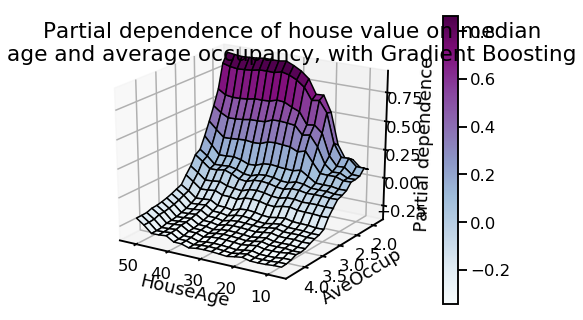

In [45]:
"""
========================
Partial Dependence Plots
========================

Partial dependence plots show the dependence between the target function [2]_
and a set of 'target' features, marginalizing over the
values of all other features (the complement features). Due to the limits
of human perception the size of the target feature set must be small (usually,
one or two) thus the target features are usually chosen among the most
important features.

This example shows how to obtain partial dependence plots from a
:class:`~sklearn.neural_network.MLPRegressor` and a
:class:`~sklearn.ensemble.HistGradientBoostingRegressor` trained on the
California housing dataset. The example is taken from [1]_.

The plots show four 1-way and two 1-way partial dependence plots (ommitted for
:class:`~sklearn.neural_network.MLPRegressor` due to computation time).
The target variables for the one-way PDP are: median income (`MedInc`),
average occupants per household (`AvgOccup`), median house age (`HouseAge`),
and average rooms per household (`AveRooms`).

.. [1] T. Hastie, R. Tibshirani and J. Friedman,
    "Elements of Statistical Learning Ed. 2", Springer, 2009.

.. [2] For classification you can think of it as the regression score before
       the link function.
"""
print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets.california_housing import fetch_california_housing


##############################################################################
# California Housing data preprocessing
# -------------------------------------
#
# Center target to avoid gradient boosting init bias: gradient boosting
# with the 'recursion' method does not account for the initial estimator
# (here the average target, by default)
#
cal_housing = fetch_california_housing()
names = cal_housing.feature_names
X, y = cal_housing.data, cal_housing.target

y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=0)

##############################################################################
# Partial Dependence computation
# ------------------------------
#
# Let's fit the models and compute the partial dependence plots either
# or one or two variables at a time.

print("Training MLPRegressor...")
tic = time()
est = make_pipeline(QuantileTransformer(),
                    MLPRegressor(hidden_layer_sizes=(50, 50),
                                 learning_rate_init=0.01,
                                 max_iter=200,
                                 early_stopping=True,
                                 n_iter_no_change=10,
                                 validation_fraction=0.1))
est.fit(X_train, y_train)
print("done in {:.3f}s".format(time() - tic))
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))

print('Computing partial dependence plots...')
tic = time()
# We don't compute the 2-way PDP (5, 1) here, because it is a lot slower
# with the brute method.
features = [0, 5, 1, 2]
plot_partial_dependence(est, X_train, features, feature_names=names,
                        n_jobs=3, grid_resolution=20)
print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.suptitle('Partial dependence of house value on non-location features\n'
             'for the California housing dataset, with MLPRegressor')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

print("Training GradientBoostingRegressor...")
tic = time()
est = HistGradientBoostingRegressor(max_iter=100, max_leaf_nodes=64,
                                    learning_rate=0.1, random_state=1)
est.fit(X_train, y_train)
print("done in {:.3f}s".format(time() - tic))
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))

print('Computing partial dependence plots...')
tic = time()
features = [0, 5, 1, 2, (5, 1)]
plot_partial_dependence(est, X_train, features, feature_names=names,
                        n_jobs=3, grid_resolution=20)
print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.suptitle('Partial dependence of house value on non-location features\n'
             'for the California housing dataset, with Gradient Boosting')
plt.subplots_adjust(top=0.9)

##############################################################################
# Analysis of the plots
# ---------------------
#
# We can clearly see that the median house price shows a linear relationship
# with the median income (top left) and that the house price drops when the
# average occupants per household increases (top middle).
# The top right plot shows that the house age in a district does not have
# a strong influence on the (median) house price; so does the average rooms
# per household.
# The tick marks on the x-axis represent the deciles of the feature values
# in the training data.
#
# We also observe that :class:`~sklearn.neural_network.MLPRegressor` has much
# smoother predictions than
# :class:`~sklearn.ensemble.HistGradientBoostingRegressor`. For the plots to be
# comparable, it is necessary to subtract the average value of the target
# ``y``: The 'recursion' method, used by default for
# :class:`~sklearn.ensemble.HistGradientBoostingRegressor`, does not account
# for the initial predictor (in our case the average target). Setting the
# target average to 0 avoids this bias.
#
# Partial dependence plots with two target features enable us to visualize
# interactions among them. The two-way partial dependence plot shows the
# dependence of median house price on joint values of house age and average
# occupants per household. We can clearly see an interaction between the
# two features: for an average occupancy greater than two, the house price is
# nearly independent of the house age, whereas for values less than two there
# is a strong dependence on age.

##############################################################################
# 3D interaction plots
# --------------------
#
# Let's make the same partial dependence plot for the 2 features interaction,
# this time in 3 dimensions.

fig = plt.figure()

target_feature = (1, 5)
pdp, axes = partial_dependence(est, X_train, target_feature,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on median\n'
             'age and average occupancy, with Gradient Boosting')
plt.subplots_adjust(top=0.9)

plt.show()


Permutation Importance vs Random Forest Feature Importance

.. currentmodule:: sklearn.inspection

In this example, we will compare the
:class:`sklearn.ensemble.RandomForestClassifier` feature importance with the
permutation importance on the titanic dataset using
:func:`permutation_importance`. We will show that the random
forest feature importance can inflate the importance of numerical features.

Furthermore, the built-in feature importance of random forests suffers from
being computed on statistics derived from the training dataset: the
importances can be high even for features that are not predictive of the target
variable, as long as the model has the capacity to use them to overfit.

This example shows how to use Permutation Importances as an alternative that
can mitigate those limitations.

.. topic:: References:

   .. [1] Strobl, C., Boulesteix, AL., Zeileis, A. et al. BMC Bioinformatics
        (2007) 8: 25. https://doi.org/10.1186/1471-2105-8-25

RF train accuracy: 1.000
R

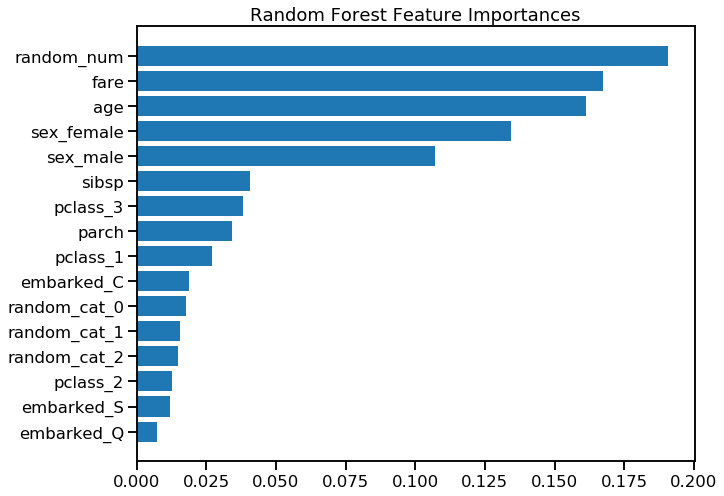

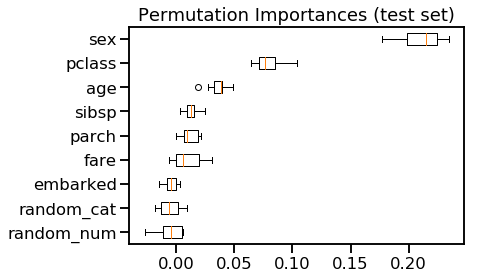

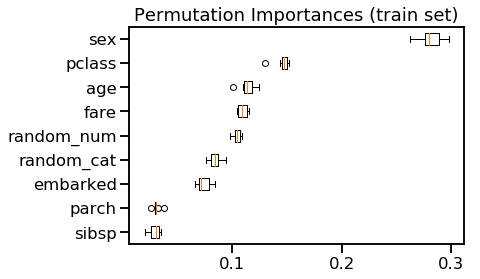

In [46]:
"""
==========================================================
Permutation Importance vs Random Forest Feature Importance
==========================================================

.. currentmodule:: sklearn.inspection

In this example, we will compare the
:class:`sklearn.ensemble.RandomForestClassifier` feature importance with the
permutation importance on the titanic dataset using
:func:`permutation_importance`. We will show that the random
forest feature importance can inflate the importance of numerical features.

Furthermore, the built-in feature importance of random forests suffers from
being computed on statistics derived from the training dataset: the
importances can be high even for features that are not predictive of the target
variable, as long as the model has the capacity to use them to overfit.

This example shows how to use Permutation Importances as an alternative that
can mitigate those limitations.

.. topic:: References:

   .. [1] Strobl, C., Boulesteix, AL., Zeileis, A. et al. BMC Bioinformatics
        (2007) 8: 25. https://doi.org/10.1186/1471-2105-8-25
"""
print(__doc__)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


##############################################################################
# Data Loading and Feature Engineering
# ------------------------------------
# Let's use pandas to load a copy of the titanic dataset. The following shows
# how to apply separate preprocessing on numerical and categorical features.
#
# We further include two random variables that are not correlated in any way
# with the target variable (``survived``):
#
# - ``random_num`` is a high cardinality numerical variable (as many unique
# values as records);
# - ``random_cat`` is a low cardinality categorical variable (3 possible
#   values).
titanic_url = ('https://raw.githubusercontent.com/amueller/'
               'scipy-2017-sklearn/091d371/notebooks/datasets/titanic3.csv')
titanic = pd.read_csv(titanic_url)
titanic['random_cat'] = np.random.randint(3, size=titanic.shape[0])
titanic['random_num'] = np.random.randn(titanic.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

data = titanic[categorical_columns + numerical_columns]
labels = titanic['survived']

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, stratify=labels, random_state=42)

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_estimators=100, min_samples_leaf=1,
                                          random_state=42))
])
rf.fit(X_train, y_train)

##############################################################################
# Accuracy of the Model
# ---------------------
# Prior to inspecting the feature importances, it is important to check that
# the model predictive performance is high enough. Indeed there would be little
# interest of inspecting the important features of a non-predictive model.
#
# Here one can observe that the train accuracy is very high (the forest model
# has enough capacity to completely memorize the training set) but it can still
# generalize well enough to the test set thanks to the built-in bagging of
# random forests.
#
# It might be possible to trade some accuracy on the training set for a
# slightly better accuracy on the test set by limiting the capacity of the
# trees (for instance by setting ``max_samples_leaf=5`` or
# ``max_samples_leaf=10``) so as to limit overfitting while not introducing too
# much underfitting.
#
# However let's keep our high capacity random forest model for now so as to
# illustrate some pitfalls with feature importance on variables with many
# unique values.
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))


##############################################################################
# Tree Based Feature Importance
# -----------------------------
# The tree based feature importance ranks the numerical features to be the
# most important features. As a result, the non-predictive ``random_num``
# variable is ranked the most important!
#
# This problem stems from two limitations of RF feature importances:
#
# - RF importances are biased towards high cardinality features;
# - RF importances are computed on training set statistics and therefore do not
# reflect the ability of feature to be useful to make predictions that
# generalize to the test set (when the model has enough capacity).
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = []
for col, cats in zip(categorical_columns, ohe.categories_):
    for cat in cats:
        feature_names.append("{}_{}".format(col, cat))
feature_names = np.array(feature_names + numerical_columns)

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
_, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")


##############################################################################
# As an alternative, the permutation importances of ``rf`` are computed on a
# held out test set. This shows that the low cardinality categorical feature,
# ``sex`` is the most important feature.
#
# Also note that both random features have very low importances (close to 0) as
# expected.
permute_importance = permutation_importance(rf, X_test, y_test, n_rounds=10,
                                            random_state=42)
permute_importance_mean = np.mean(permute_importance, axis=-1)
sorted_idx = permute_importance_mean.argsort()

# sphinx_gallery_thumbnail_number = 2
_, ax = plt.subplots()
ax.boxplot(permute_importance[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

##############################################################################
# It is also possible to compute the permutation importances on the training
# set. This reveals that ``random_num`` gets a significantly higher importance
# ranking than when computed on the test set. The difference between those two
# plots is a confirmation that the RF model has enough capacity to use that
# random numerical feature to overfit. You can further confirm this by
# re-running this example with constrained RF with min_samples_leaf=10.
permute_importance = permutation_importance(rf, X_train, y_train, n_rounds=10,
                                            random_state=42)
permute_importance_mean = np.mean(permute_importance, axis=-1)
sorted_idx = permute_importance_mean.argsort()

# sphinx_gallery_thumbnail_number = 3
_, ax = plt.subplots()
ax.boxplot(permute_importance[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
plt.show()



Permutation Importance with Multicollinear Features

.. currentmodule:: sklearn.inspection

In this example, we compute the permutation importance on the Wisconsin
breast cancer dataset using :func:`permutation_importance`.
The :class:`sklearn.ensemble.RandomForestClassifier` can easily get about 97%
accuracy on a test dataset with a unsurprising tree based feature importance
graph. Because this dataset contains multicollinear features, the permutation
importance will show that none of the features are important.
We handle the multicollinearity by performing hierarchical clustering on the
features' Spearman rank-order correlations, picking a threshold, and keeping a
single feature from each cluster.

.. note::
    See also
    :ref:`sphx_glr_auto_examples_inspection_plot_permutation_importance.py`

Accuracy on test data: 0.97


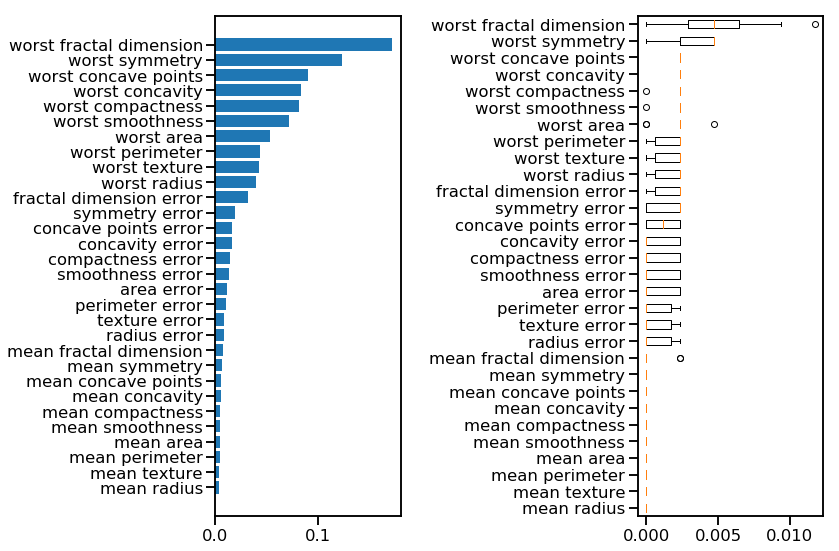

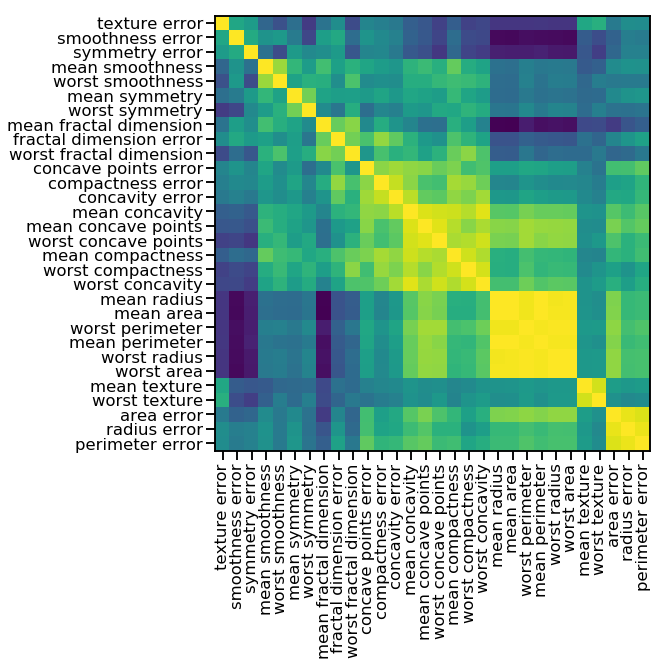

Accuracy on test data with features removed: 0.97


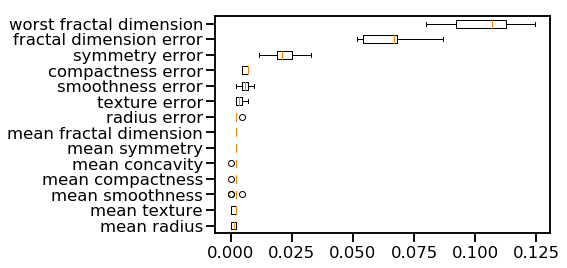

In [47]:
"""
===================================================
Permutation Importance with Multicollinear Features
===================================================

.. currentmodule:: sklearn.inspection

In this example, we compute the permutation importance on the Wisconsin
breast cancer dataset using :func:`permutation_importance`.
The :class:`sklearn.ensemble.RandomForestClassifier` can easily get about 97%
accuracy on a test dataset with a unsurprising tree based feature importance
graph. Because this dataset contains multicollinear features, the permutation
importance will show that none of the features are important.
We handle the multicollinearity by performing hierarchical clustering on the
features' Spearman rank-order correlations, picking a threshold, and keeping a
single feature from each cluster.

.. note::
    See also
    :ref:`sphx_glr_auto_examples_inspection_plot_permutation_importance.py`
"""
print(__doc__)
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

##############################################################################
# Random Forest Feature Importance on Breast Cancer Data
# ------------------------------------------------------
# First, we train a random forest on the breast cancer dataset and evaluate
# its accuracy on a test set:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

##############################################################################
# Next, we plot the tree based feature importance and the permutation
# importance. The permutation importance plot shows that permuting a feature
# drops the accuracy by at most `0.012`, which would suggest that none of the
# features are important. This is in contradiction with the high test accuracy
# computed above: some feature must be important. The permutation importance
# is calculated on the training set to show how much the model relies on each
# feature during training.
perm_importance = permutation_importance(clf, X_train, y_train, n_rounds=10,
                                         random_state=42)
perm_sorted_idx = np.mean(perm_importance, axis=-1).argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indicies = np.arange(1, len(clf.feature_importances_) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indicies, clf.feature_importances_[tree_importance_sorted_idx])
ax1.set_yticklabels(data.feature_names)
ax1.set_yticks(tree_indicies)
ax2.boxplot(perm_importance[perm_sorted_idx].T, vert=False,
            labels=data.feature_names)
fig.tight_layout()
plt.show()

##############################################################################
# Handling Multicollinear Features
# --------------------------------
# When features are collinear, permutating one feature will have little
# effect on the models performance because it can get the same information
# from a correlated feature. One way to handle multicollinear features is by
# performing hierarchical clustering on the Spearman rank-order correlations,
# picking a threshold, and keeping a single feature from each cluster. First,
# we plot a heatmap of the correlated features:
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, no_plot=True)
dendro_order = np.array(dendro['ivl'], dtype='int')
dendro_idx = np.arange(0, len(dendro_order))

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(corr[dendro_order, :][:, dendro_order])
ax.set_xticks(dendro_idx)
ax.set_yticks(dendro_idx)
ax.set_xticklabels(data.feature_names[dendro_order], rotation='vertical')
ax.set_yticklabels(data.feature_names[dendro_order])
plt.show()

##############################################################################
# Next, we pick a threshold to group our features into clusters and choose a
# feature from each cluster to keep, select those features from our dataset,
# and train a new random forest. The test accuracy of the new random forest did
# not changed much compared to the random forest trained on the complete
# dataset.
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

##############################################################################
# Lastly, we plot the permutation importance with new random forest on the
# test dataset.
perm_importance_sel = permutation_importance(clf_sel, X_train_sel,
                                             y_train, n_rounds=10,
                                             random_state=42)
perm_sorted_sel_idx = np.mean(perm_importance_sel, axis=-1).argsort()
_, ax = plt.subplots()
ax.boxplot(perm_importance_sel[perm_sorted_sel_idx].T, vert=False,
           labels=data.feature_names[selected_features])
plt.show()

## Appendix

### Effect plots for linear models

In [48]:
from sklearn.preprocessing import StandardScaler

X = censing.data[censing.feature_names]
y = censing.data[censing.target_names].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    (StandardScaler(), numerical_columns)
)

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
model.fit(X_train, y_train);

In [49]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

We can check the effect of the coefficients on the original data by multiplying the coefficients of the linear model by the original data (preprocessed).

In [50]:
X_train_preprocessed = pd.DataFrame(
    model.named_steps['columntransformer'].transform(X_train),
    columns=feature_names
)
effect = X_train_preprocessed * model.named_steps['transformedtargetregressor'].regressor_.coef_

# For the categorical variable, we can inverse the one-hot encoding since only one of the category will be non-null
effect_decoded = {}
for cat in categorical_columns:
    cat_cols = effect.columns.str.contains(cat)
    effect_cat = effect.loc[:, cat_cols]
    idx_filter = (effect_cat != 0).values
    effect_decoded[cat] = effect_cat.values[idx_filter]
# For the other columns, we don't need to inverse any embedding
for col in binary_columns + numerical_columns:
    effect_decoded[col] = effect[col]
effect = pd.DataFrame(effect_decoded)

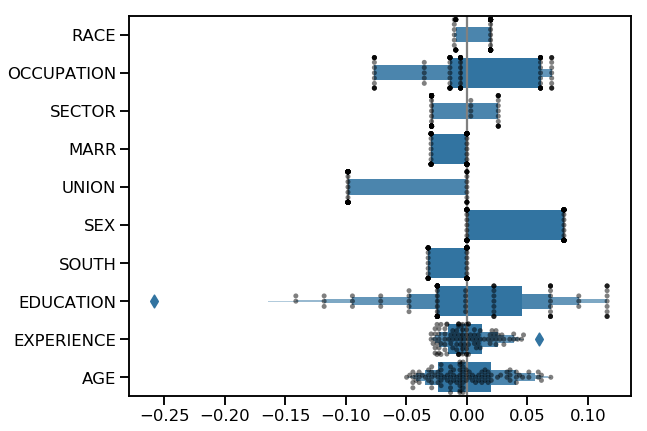

In [51]:
plt.figure(figsize=(9, 7))
# subsample for the swarmplot
sns.swarmplot(data=effect.sample(100), orient='h', color='k', alpha=0.5)
sns.boxenplot(data=effect, orient='h', color='C0')
plt.axvline(x=0, color='.5');

The largest contribution to the expected wages is related to the "EDUCATION" due to the large variance in the effect plot.

## References

[1] Interpretable Machine Learning, Christph Molnar, 2019. https://github.com/christophM/interpretable-ml-book